# GSDAE (Group Selective Deep AutoEncoder) for Danshen Analysis

基于方案文档的改进版本，包含：
1. 组稀疏正则化 (Group Lasso)
2. 半监督学习机制
3. 预测头 (Prediction Head)
4. 复合损失函数
5. 两层重要性分析

## 环境与库导入：标准科学栈 + TensorFlow + keras_tuner（但后续未真正使用调参逻辑）。

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os

from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

import glob

import seaborn as sns  # 新增

from sklearn.preprocessing import StandardScaler
import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from tensorflow.keras import regularizers

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import optimizers, initializers
from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau

import keras_tuner as kt

## Data Loading and Preprocessing

## 数据加载与合并：遍历目录下多个 CSV，分离目标列，按样本 ID 内连接合并特征。

In [2]:
# --- 1. 定义特征文件所在的目录 ---
feature_files_dir = './data_R/EnvironmentGroup/'
sample_id_col = 'SampleN' # <--- 假设每个文件里都有这个样本ID列

# --- 2. 查找所有特征文件 ---
csv_files = glob.glob(os.path.join(feature_files_dir, '*.csv'))
if not csv_files:
    raise FileNotFoundError(f"在目录 '{feature_files_dir}' 中没有找到任何CSV文件。")

print(f"找到了 {len(csv_files)} 个特征文件。")

# --- 3. 从第一个文件中获取目标变量 ---
try:
    first_df = pd.read_csv(csv_files[0])
    # 假设目标变量是最后一列
    target_column_name = first_df.columns[-1]
    # 提取目标变量和样本ID，并设置索引
    main_target = first_df[[sample_id_col, target_column_name]].set_index(sample_id_col)
    print(f"目标变量 '{target_column_name}' 已从 '{os.path.basename(csv_files[0])}' 中分离。")
except (IndexError, KeyError) as e:
    raise ValueError(f"无法从文件 {csv_files[0]} 中提取目标变量或样本ID: {e}")

# --- 4. 循环读取所有文件，合并特征 ---
all_feature_dfs = []
for file_path in csv_files:
    try:
        # 读取数据，并将样本ID设为索引
        df = pd.read_csv(file_path).set_index(sample_id_col)
        # 删除目标列，只保留特征
        features_only = df.drop(columns=[target_column_name])
        all_feature_dfs.append(features_only)
    except (FileNotFoundError, KeyError) as e:
        print(f"警告：处理文件 {file_path} 时出错，已跳过。错误: {e}")

# --- 5. 合并所有特征 ---
# 使用 outer join 以保留所有样本，缺失处会用NaN填充
# 使用 inner join 只保留所有文件中都存在的样本
feature_data = pd.concat(all_feature_dfs, axis=1, join='inner')

# --- 6. 对齐特征和目标 ---
# 确保 feature_data 和 main_target 的样本索引一致
common_samples = feature_data.index.intersection(main_target.index)
feature_data = feature_data.loc[common_samples]
main_target = main_target.loc[common_samples]

print(f"\n合并后的特征数据形状: {feature_data.shape}")
print(f"对齐后的目标变量形状: {main_target.shape}")

找到了 4 个特征文件。
目标变量 'SumTS' 已从 'climate.csv' 中分离。

合并后的特征数据形状: (991, 69)
对齐后的目标变量形状: (991, 1)


## 预处理：列缺失率阈值过滤 + 行级完整性过滤 + 类别特征独热编码 + 标准化（X 与 y 都用 StandardScaler）。

In [3]:
# --- 数据预处理 ---
# 1. 处理缺失值：删除特征超过50%缺失的列
thresh = len(feature_data) * 0.5
feature_data = feature_data.dropna(axis=1, thresh=thresh)

# 2. 处理缺失值：删除任何包含缺失值的行（样本）
# 首先合并，然后删除带有任何NaN的行，最后再分开，以确保对齐
temp_df = pd.concat([feature_data, main_target], axis=1)
temp_df.dropna(inplace=True)

# 重新分离
feature_data = temp_df.drop(columns=main_target.columns)
main_target = temp_df[main_target.columns]

# 3. 独热编码
categorical_columns = ["Province", "City", "Microb", "Landscape", "SoilType", "soilclass", "CultivationType", "ClimateType", "按气候聚类划分的类型"]
categorical_columns = [col for col in categorical_columns if col in feature_data.columns]
if categorical_columns:
    feature_data = pd.get_dummies(feature_data, columns=categorical_columns, drop_first=True)

print(f"预处理后特征数据形状: {feature_data.shape}")
print(f"预处理后目标变量形状: {main_target.shape}")

预处理后特征数据形状: (498, 72)
预处理后目标变量形状: (498, 1)


In [4]:
# 数据分割和标准化
X_train, X_test, y_train, y_test = train_test_split(feature_data, main_target, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scal = scaler_X.fit_transform(X_train)
X_test_scal = scaler_X.transform(X_test)
y_train_scal = scaler_y.fit_transform(y_train)
y_test_scal = scaler_y.transform(y_test)

# --- 新增：提前反标准化 y_test，为后续评估做准备 ---
y_test_orig = scaler_y.inverse_transform(y_test_scal)

feature_names = list(feature_data.columns)
print(f"训练集: {X_train_scal.shape}, 测试集: {X_test_scal.shape}")
print(f"特征总数: {len(feature_names)}")

训练集: (398, 72), 测试集: (100, 72)
特征总数: 72


## Feature Grouping

## 特征分组：三种模式 external/custom/auto；当前默认 external 读取目录列名映射到现有特征索引，再无结果则回退 auto 启发式。

In [5]:
# ...existing code...
def _find_indices_by_names(feature_names, names_list):
    """在 feature_names 中匹配 names_list（支持精确/包含/前缀），返回索引列表（去重、有序）"""
    fn_lower = [f.lower() for f in feature_names]
    indices = []
    names_lower = [n.lower() for n in names_list]
    for i, fname in enumerate(fn_lower):
        for nm in names_lower:
            if fname == nm or nm in fname or fname.startswith(nm) or fname.endswith(nm):
                indices.append(i)
                break
    return sorted(set(indices))

def create_feature_groups(feature_names, method='external', external_dir='./data_R/EnvironmentGroup', custom_groups=None):
    """
    创建特征分组。
    method: 'external'|'custom'|'auto'
      - 'external'：从 external_dir 中读取所有 csv 文件（每个文件视为一组，使用列名映射）
      - 'custom'：使用 custom_groups 字典 {group_name: [names_or_substrings,...]}
      - 'auto'：使用启发式规则（原始逻辑）
    返回: dict {group_name: [indices,...]}
    """
    feature_names = list(feature_names)
    groups = {}

    if method == 'external':
        # 找到目录下的 csv 文件
        if os.path.exists(external_dir):
            csv_files = sorted(glob.glob(os.path.join(external_dir, '*.csv')))
            for fp in csv_files:
                gname = os.path.splitext(os.path.basename(fp))[0]
                try:
                    df = pd.read_csv(fp)
                except Exception:
                    continue
                # 常见情况：文件里有 SampleN 列，去掉
                cols = [c for c in df.columns if c.lower() not in ('samplen', 'sample_n', 'sampleid', 'sample_id')]
                # 如果文件包含目标列（如 SumTS），自动剔除
                cols = [c for c in cols if c not in ('SumTS', 'SumTS'.lower())]
                idxs = _find_indices_by_names(feature_names, cols)
                if idxs:
                    groups[gname] = idxs
        # 如果没有读取到任何组，回退到 auto
        if not groups:
            method = 'auto'

    if method == 'custom' and custom_groups:
        for gname, name_list in custom_groups.items():
            idxs = _find_indices_by_names(feature_names, name_list)
            if idxs:
                groups[gname] = idxs
        # allow fall back to auto if empty
        if not groups:
            method = 'auto'

    if method == 'auto':
        # 原始启发式规则的改进版本
        ee_elements = {'mn', 'cu', 'fe', 'zn', 'mg', 'k', 'ca', 'mo'}
        be_elements = {'v', 'na', 'co'}
        hm_elements = {'pb', 'cr', 'cd', 'as', 'sb', 'sn'}
        re_elements = {'y', 'la', 'ce', 'pr', 'nd', 'sm', 'eu', 'gd', 'tb', 'dy', 'ho', 'er', 'yb', 'th'}
        oe_elements = {'ga', 'rb', 'li', 'sr', 'ba', 'be', 'cs', 'ni', 'sc', 'ge', 'hf', 'nb', 'ti', 'zr'}

        tmp = {
            '必需元素': [],
            '有益元素': [],
            '重金属元素': [],
            '稀土元素': [],
            '其他元素': [],
            '土壤元素': [],
            '理化性质': [],
            '地理信息': [],
            '气候环境': [],
            '理化+元素': []
        }

        for i, name in enumerate(feature_names):
            nl = name.lower()
            # 气候环境关键字（可扩展）
            if any(k in nl for k in ['di','gdd0','gdd5','gp','mi','mtco','mtwa','tmax','tmin','precip','ppt','temp']):
                tmp['气候环境'].append(i)
                continue
            # 土壤元素标识
            if nl.endswith('_s') or nl.endswith('_S') or nl.endswith('_soil'):
                tmp['土壤元素'].append(i)
                continue
            # 理化性质
            if any(k in nl for k in ['ph', 'ec', 'nh4_n', 'no3_n', 'tn', 'om', 'an_x', 'ap_x', 'ak_x', 'soiltypenum', 'cec']):
                tmp['理化性质'].append(i)
                continue
            # 地理信息
            if any(k in nl for k in ['longitude', 'latitude', 'alt', 'elevation']):
                tmp['地理信息'].append(i)
                continue
            # 元素分类（尝试解析前缀如 'mn_s'）
            token = nl.split('_')[0]
            if token in ee_elements:
                tmp['必需元素'].append(i)
                continue
            if token in be_elements:
                tmp['有益元素'].append(i)
                continue
            if token in hm_elements:
                tmp['重金属元素'].append(i)
                continue
            if token in re_elements:
                tmp['稀土元素'].append(i)
                continue
            if token in oe_elements:
                tmp['其他元素'].append(i)
                continue
            # 其它情况可放到理化+元素
            if any(ch in nl for ch in ['element', 'conc', 'mg', 'ppm', 'mgkg']):
                tmp['理化+元素'].append(i)

        # 移除空组
        groups = {k: v for k, v in tmp.items() if len(v) > 0}

    return groups

# --- 示例：三种用法（按需修改） ---
# 1) external（优先尝试读取 c:\\.../data_R/ElementGroup 中的 CSV）
feature_groups = create_feature_groups(feature_names, method='external', external_dir='./data_R/EnvironmentGroup')

# 2) custom（若你想手工指定分组规则，取消下面注释并修改）
# custom = {
#     '必需元素': ['mn','cu','fe','zn','mg','k','ca','mo'],
#     '有益元素': ['v','na','co'],
#     '重金属': ['pb','cr','cd','as'],
# }
# feature_groups = create_feature_groups(feature_names, method='custom', custom_groups=custom)

# 3) auto（使用启发式规则）
# feature_groups = create_feature_groups(feature_names, method='auto')

# 打印结果
print(f"创建了 {len(feature_groups)} 个特征组:")
for group_name, indices in feature_groups.items():
    print(f"  - {group_name}: {len(indices)} 个特征")
# ...existing code...

创建了 4 个特征组:
  - climate: 9 个特征
  - geo: 6 个特征
  - physicochemical: 15 个特征
  - soil_element: 45 个特征


## GSDAE Model Definition

## GroupSelectiveLayer：逐特征可训练权重 + 手动 Group Lasso（L2）与 L1 正则（通过 add_loss）。

In [6]:
class ZeroToOneClip(tf.keras.constraints.Constraint):
    """权重约束：限制在0-1之间"""
    def __call__(self, w):
        return tf.clip_by_value(w, 0, 1)

class GroupSelectiveLayer(keras.layers.Layer):
    """组选择层 - 支持组稀疏正则化的特征选择层"""
    def __init__(self, feature_groups, group_lasso_rate=0.01, l1_rate=0.001, **kwargs):
        super().__init__(**kwargs)
        self.feature_groups = feature_groups
        self.group_lasso_rate = group_lasso_rate
        self.l1_rate = l1_rate
        
    def build(self, input_shape):
        self.kernel = self.add_weight(
            "kernel", 
            shape=(int(input_shape[-1]),),
            
            # 修改初始化范围
            initializer=initializers.RandomUniform(minval=0.5, maxval=1.0),  # 修改初始化范围
            constraint=ZeroToOneClip(),
            trainable=True
        )
        
    def call(self, inputs):
        weighted_features = tf.multiply(inputs, self.kernel)
        
        # 添加组稀疏正则化损失
        group_loss = 0.0
        for group_indices in self.feature_groups.values():
            if len(group_indices) > 0:
                group_weights = tf.gather(self.kernel, group_indices)
                group_l2_norm = tf.norm(group_weights, ord=2)
                group_loss += group_l2_norm
        
        l1_loss = tf.reduce_sum(tf.abs(self.kernel))
        
        # 添加数值稳定性检查
        group_loss = tf.clip_by_value(group_loss, 0.0, 1e6)
        l1_loss = tf.clip_by_value(l1_loss, 0.0, 1e6)
        
        self.add_loss(self.group_lasso_rate * group_loss)
        self.add_loss(self.l1_rate * l1_loss)
        
        return weighted_features

这里检查一下

# --- 创新点：添加组注意力层 ---

## GroupAttentionLayer：对每组投影后多头注意力，得到组权重，再用单一组权重缩放组内全部特征。

In [7]:
# --- 创新点：添加组注意力层 ---
class GroupAttentionLayer(keras.layers.Layer):
    """
    组注意力层 (Group Attention Layer)
    1. 将输入特征按组分割。
    2. 对每组特征进行聚合（例如，通过一个Dense层），生成一个代表该组的向量。
    3. 使用多头自注意力机制计算这些组向量之间的关系，并得到注意力权重。
    4. 将注意力权重应用回原始的组特征上。
    5. 将加权后的组特征重新拼接，作为最终输出。
    """
    def __init__(self, feature_groups, projection_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.feature_groups = feature_groups
        self.group_order = list(feature_groups.keys()) # 保证组的顺序固定
        self.num_groups = len(self.group_order)
        self.projection_dim = projection_dim
        self.num_heads = num_heads

        # 用于将每个不同大小的组投影到相同维度的Dense层
        self.projection_layers = [Dense(projection_dim, activation='relu', name=f'projection_{name}') for name in self.group_order]
        
        # 核心：多头注意力层
        self.attention = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, name='group_attention')
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        
        # 前馈网络
        self.ffn = keras.Sequential([
            Dense(projection_dim * 2, activation="relu"),
            Dense(projection_dim),
        ], name='ffn')

    def call(self, inputs):
        # inputs shape: (batch_size, total_features)
        
        # 1. 按组分割特征
        group_tensors = []
        for group_name in self.group_order:
            indices = self.feature_groups[group_name]
            group_tensor = tf.gather(inputs, indices, axis=1)
            group_tensors.append(group_tensor)

        # 2. 将每个组投影到固定维度
        projected_groups = [self.projection_layers[i](group_tensors[i]) for i in range(self.num_groups)]
        
        # 3. 堆叠成序列，准备输入注意力层
        sequence = tf.stack(projected_groups, axis=1)
        
        # 4. 应用多头自注意力
        attention_output, attention_scores = self.attention(
            query=sequence, 
            value=sequence, 
            key=sequence,
            return_attention_scores=True
        )
        
        # 5. 残差连接和层归一化
        attn_out_norm = self.layer_norm1(sequence + attention_output)
        
        # 6. 前馈网络
        ffn_output = self.ffn(attn_out_norm)
        ffn_out_norm = self.layer_norm2(attn_out_norm + ffn_output)
        
        # 7. 计算最终的组注意力权重 (用于模型输出)
        group_attention_weights = tf.reduce_mean(tf.reduce_sum(attention_scores, axis=2), axis=1)
        group_attention_weights = tf.nn.softmax(group_attention_weights, axis=-1)
        
        # --- 核心修改：使用加权和拼接代替 scatter_update ---
        # 8. 将注意力权重应用回原始组特征
        weighted_groups = []
        for i in range(self.num_groups):
            # 获取对应组的原始特征
            original_group_tensor = group_tensors[i]
            # 获取对应组的注意力权重，并扩展维度以进行广播
            weight = group_attention_weights[:, i:i+1] # Shape: (batch_size, 1)
            # 加权
            weighted_group = original_group_tensor * weight
            weighted_groups.append(weighted_group)

        # 9. 创建一个全零的列表，用于按原始顺序放置加权后的组
        num_features = inputs.shape[1]
        # 使用一个字典来按索引存储加权后的组
        placeholder = {}
        for i, group_name in enumerate(self.group_order):
            indices = self.feature_groups[group_name]
            weighted_group = weighted_groups[i]
            # 将加权后的组按特征维度拆分
            split_tensors = tf.split(weighted_group, num_or_size_splits=weighted_group.shape[1], axis=1)
            for j, index in enumerate(indices):
                placeholder[index] = split_tensors[j]
        
        # 10. 按原始特征顺序重组张量
        final_output_tensors = [placeholder[i] for i in range(num_features)]
        final_output = tf.concat(final_output_tensors, axis=1)
            
        return final_output, group_attention_weights

# --- 创新点：包含注意力机制的GSDAE模型构建函数 ---

## 主模型：选择层 → 注意力层 → 编码器 → bottleneck → 预测头 → 解码器 → 重构输出 + 预测输出 + 注意力分数输出。

In [8]:
# --- 创新点：包含注意力机制的GSDAE模型构建函数 ---
def build_GSDAE_with_Attention(input_shape, target_dim, feature_groups, 
                               nbr_hidden_layers=3, hidden_layer_shape=12, 
                               encodings_nbr=6, group_lasso_rate=0.01, l1_rate=0.001,
                               projection_dim=32, num_heads=4):
    """构建带有组注意力机制的GSDAE模型"""
    
    # 输入层
    feature_inputs = Input(shape=[input_shape], name='input')
    
    # 1. 组内特征选择层 (与之前相同)
    group_selective_layer = GroupSelectiveLayer(
        feature_groups=feature_groups,
        group_lasso_rate=group_lasso_rate,
        l1_rate=l1_rate,
        name='improved_group_selective_layer'
    )
    selected_features = group_selective_layer(feature_inputs)
    
    # 2. 组间注意力层 (新添加)
    group_attention_layer = GroupAttentionLayer(
        feature_groups=feature_groups,
        projection_dim=projection_dim,
        num_heads=num_heads,
        name='group_attention_layer'
    )
    # 注意力层返回加权后的特征和组的注意力分数
    attended_features, group_attention_scores = group_attention_layer(selected_features)
    
    # --- 新增修改：为注意力分数输出张量赋予明确的名称 ---
    # 使用一个无操作的激活层来给张量命名，这是Keras中的一个常用技巧
    group_attention_scores = tf.keras.layers.Activation('linear', name='attention_scores')(group_attention_scores)
    
    # --- 后续结构与原模型基本一致，但输入变为 attended_features ---
    
    # 编码器
    encoder_select = attended_features
    for i in range(nbr_hidden_layers):
        encoder_select = Dense(hidden_layer_shape, activation='linear', name=f'encoder_hidden_layer_select_{i}')(encoder_select)
        encoder_select = keras.layers.LeakyReLU(alpha=0.01)(encoder_select)
        encoder_select = keras.layers.BatchNormalization()(encoder_select)
    
    # 编码层
    encoding_select = Dense(encodings_nbr, activation='linear', name='encoding_layer_select')(encoder_select)
    encoding_select = keras.layers.LeakyReLU(alpha=0.01)(encoding_select)
    
    # 预测头
    prediction_head = Dense(32, activation='linear', name='pred_hidden')(encoding_select)
    prediction_head = keras.layers.LeakyReLU(alpha=0.01)(prediction_head)
    prediction_head = keras.layers.BatchNormalization()(prediction_head)
    target_prediction = Dense(target_dim, activation='linear', name='target_prediction')(prediction_head)
    
    # 解码器
    decoder_layers = []
    for i in range(nbr_hidden_layers):
        decoder_layer = Dense(hidden_layer_shape, activation='linear', name=f'decoder_hidden_layer_{i}')
        decoder_layers.append(decoder_layer)
    
    
    
    # 应用解码器
    decoder_select = encoding_select
    for decoder_layer in decoder_layers:
        decoder_select = decoder_layer(decoder_select)
        decoder_select = keras.layers.LeakyReLU(alpha=0.01)(decoder_select)
        decoder_select = keras.layers.BatchNormalization()(decoder_select)
    
    # --- 修改：为重构输出张量添加名称 ---
    reconstruction_select = Dense(input_shape, activation='linear', name='reconstruction_layer')(decoder_select)
    
    # 构建模型
    # 输出中增加了 group_attention_scores 以便后续分析
    gsdae_model = Model(
        inputs=feature_inputs, 
        outputs=[reconstruction_select, target_prediction, group_attention_scores], 
        name='AttentionGSDAE'
    )
    
    return gsdae_model, group_selective_layer, group_attention_layer

## Build Model

lasso_rate = 1e-4  # 降低L1正则化率
group_lasso_rate = 1e-3  # 降低组稀疏正则化率

定义模型参数和构建新模型

## 训练：多输出编译（第三输出用 dummy_loss + loss_weight=0），早停与 LR 调整。

In [9]:
# --- 1. 定义模型超参数 ---
# 静态重要性层参数
group_lasso_rate = 1e-3
l1_rate = 1e-4
# 注意力层参数
projection_dim = 32  # 每个组投影到的维度
num_heads = 4        # 注意力头的数量
# 网络结构参数
hidden_layer_shape = 12
nbr_hidden_layers = 3
encodings_nbr = 6
# 训练参数
learning_rate = 1e-3
prediction_weight = 0.2 # 预测任务的损失权重
batch_size = 32
epochs = 150

print("模型参数定义完成。")

# --- 2. 构建带有注意力机制的GSDAE模型 ---
# 注意：我们现在调用新的构建函数
AttentionGSDAE, group_selective_layer, group_attention_layer = build_GSDAE_with_Attention(
    input_shape=X_train_scal.shape[1],
    target_dim=y_train_scal.shape[1],
    feature_groups=feature_groups,
    nbr_hidden_layers=nbr_hidden_layers,
    hidden_layer_shape=hidden_layer_shape,
    encodings_nbr=encodings_nbr,
    group_lasso_rate=group_lasso_rate,
    l1_rate=l1_rate,
    projection_dim=projection_dim,
    num_heads=num_heads
)

# --- 3. 打印模型结构以确认 ---
print("\n带有注意力机制的GSDAE模型结构:")
AttentionGSDAE.summary()

模型参数定义完成。

带有注意力机制的GSDAE模型结构:
Model: "AttentionGSDAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 72)]         0           []                               
                                                                                                  
 improved_group_selective_layer  (None, 72)          72          ['input[0][0]']                  
  (GroupSelectiveLayer)                                                                           
                                                                                                  
 group_attention_layer (GroupAt  ((None, 72),        23648       ['improved_group_selective_layer[
 tentionLayer)                   (None, 4))                      0][0]']                          
                                                       

In [10]:
# --- 4. 编译带有注意力机制的模型 ---

# 定义一个虚拟损失函数，它永远返回0。用于我们不关心损失的输出。
def dummy_loss(y_true, y_pred):
    return 0.0

optimizer = optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)

# 关键：为模型的三个输出分别指定损失函数和损失权重
AttentionGSDAE.compile(
    optimizer=optimizer,
    loss={
        'reconstruction_layer': 'mean_squared_error',  # 重构输出的损失
        'target_prediction': 'mean_squared_error',     # 预测输出的损失
        'attention_scores': dummy_loss                 # 注意力分数输出的损失 (虚拟)
    },
    loss_weights={
        'reconstruction_layer': 1.0,                   # 重构损失的权重
        'target_prediction': prediction_weight,        # 预测损失的权重
        'attention_scores': 0.0                        # 注意力分数损失的权重 (设为0)
    },
    metrics={
        'target_prediction': ['mae', 'mse'] # 我们仍然关心预测任务的指标
    }
)

print("带有注意力机制的模型编译完成。")

带有注意力机制的模型编译完成。


In [11]:
# --- 5. 训练带有注意力机制的模型 ---

# 计算注意力输出的维度（组数）
num_groups = len(feature_groups)

# 为注意力分数输出构造“哑标签”（全零）
attn_train = np.zeros((X_train_scal.shape[0], num_groups), dtype=np.float32)
attn_val   = np.zeros((X_test_scal.shape[0],  num_groups), dtype=np.float32)

# 关键：为模型的三个输出准备对应的标签字典
train_outputs = {
    'reconstruction_layer': X_train_scal,
    'target_prediction': y_train_scal,
    'attention_scores': attn_train  # 使用全零数组，替换原来的 None
}
test_outputs = {
    'reconstruction_layer': X_test_scal,
    'target_prediction': y_test_scal,
    'attention_scores': attn_val
}

# --- 新增修改：将输入也包装成字典 ---
train_inputs = {'input': X_train_scal}
test_inputs = {'input': X_test_scal}


callbacks = [
    TerminateOnNaN(),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
]

print("开始训练模型...")
# --- 修改 fit 的调用方式 ---
history_attention_gsdae = AttentionGSDAE.fit(
    x=train_inputs, y=train_outputs,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(test_inputs, test_outputs),
    callbacks=callbacks,
    verbose=1
)

print("\n模型训练完成！")

开始训练模型...
Epoch 1/150
13/13 [==============================] - 4s 32ms/step - loss: 1.5429 - reconstruction_layer_loss: 1.2504 - target_prediction_loss: 1.3772 - attention_scores_loss: 0.0000e+00 - target_prediction_mae: 0.9188 - target_prediction_mse: 1.3772 - val_loss: 1.6096 - val_reconstruction_layer_loss: 1.4166 - val_target_prediction_loss: 0.8801 - val_attention_scores_loss: 0.0000e+00 - val_target_prediction_mae: 0.7472 - val_target_prediction_mse: 0.8801 - lr: 0.0010
Epoch 2/150
13/13 [==============================] - 0s 4ms/step - loss: 1.3813 - reconstruction_layer_loss: 1.1693 - target_prediction_loss: 0.9750 - attention_scores_loss: 0.0000e+00 - target_prediction_mae: 0.7624 - target_prediction_mse: 0.9750 - val_loss: 1.6119 - val_reconstruction_layer_loss: 1.4180 - val_target_prediction_loss: 0.8845 - val_attention_scores_loss: 0.0000e+00 - val_target_prediction_mae: 0.7460 - val_target_prediction_mse: 0.8845 - lr: 0.0010
Epoch 3/150
13/13 [==============================

定义analyze_feature_importance

In [12]:
# ...existing code...
def analyze_feature_importance(group_selective_layer, feature_groups, feature_names, 
                               metric='l2', normalize=True, top_k=None):
    """两层重要性分析；metric: 'l2'|'l1'|'max'|'mean'；normalize=True时做组大小归一化"""
    weights = group_selective_layer.kernel.numpy()

    # 组重要性评估
    group_importance = {}
    for group_name, indices in feature_groups.items():
        if len(indices) == 0:
            continue
        gw = weights[indices]

        # 可选：仅取组内Top-K权重再评估
        if top_k is not None and top_k < len(gw):
            gw = np.sort(gw)[-top_k:]

        if metric == 'l2':
            score = np.linalg.norm(gw, ord=2)
            if normalize:
                score = score / np.sqrt(len(gw))   # RMS：消除组大小影响
        elif metric == 'l1':
            score = np.sum(np.abs(gw))
            if normalize:
                score = score / len(gw)           # 平均绝对权重
        elif metric == 'max':
            score = float(np.max(gw))
        else:  # 'mean'
            score = float(np.mean(gw))
        group_importance[group_name] = float(score)

    sorted_groups = sorted(group_importance.items(), key=lambda x: x[1], reverse=True)

    # 组内关键特征识别（保持原逻辑）
    feature_importance = {}
    for group_name, indices in feature_groups.items():
        if len(indices) == 0:
            continue
        gw = weights[indices]
        gf = [feature_names[i] for i in indices]
        feature_importance[group_name] = sorted(zip(gf, gw), key=lambda x: x[1], reverse=True)

    return sorted_groups, feature_importance, weights

说是要注释掉

## Pre-training: Full AutoEncoder

## GSDAE Training

加入新的单元格启动自动调参

In [13]:
# 数据质量检查
print("=== 数据质量检查 ===")
print(f"X_train_scal - 是否包含NaN: {np.isnan(X_train_scal).any()}")
print(f"X_train_scal - 是否包含inf: {np.isinf(X_train_scal).any()}")
print(f"X_train_scal - 最大值: {X_train_scal.max():.6f}")
print(f"X_train_scal - 最小值: {X_train_scal.min():.6f}")
print(f"X_train_scal - 标准差: {X_train_scal.std():.6f}")

print(f"y_train_scal - 是否包含NaN: {np.isnan(y_train_scal).any()}")
print(f"y_train_scal - 是否包含inf: {np.isinf(y_train_scal).any()}")
print(f"y_train_scal - 最大值: {y_train_scal.max():.6f}")
print(f"y_train_scal - 最小值: {y_train_scal.min():.6f}")

# 检查是否有异常大的值
extreme_threshold = 10
extreme_features = np.abs(X_train_scal) > extreme_threshold
if extreme_features.any():
    print(f"警告: 发现 {extreme_features.sum()} 个异常大的特征值 (>10)")

print("=" * 30)

=== 数据质量检查 ===
X_train_scal - 是否包含NaN: False
X_train_scal - 是否包含inf: False
X_train_scal - 最大值: 14.986857
X_train_scal - 最小值: -3.408038
X_train_scal - 标准差: 1.000000
y_train_scal - 是否包含NaN: False
y_train_scal - 是否包含inf: False
y_train_scal - 最大值: 3.104060
y_train_scal - 最小值: -1.257309
警告: 发现 2 个异常大的特征值 (>10)


# 改进的训练策略 - 解决长期训练NaN问题

In [14]:
# NaN问题诊断工具
def diagnose_nan_issue(model, X_sample, y_sample):
    """诊断模型中的NaN问题"""
    print("=== NaN问题诊断 ===")
    
    # 1. 检查模型权重
    print("1. 检查模型权重:")
    for layer in model.layers:
        if hasattr(layer, 'kernel') and layer.kernel is not None:
            weights = layer.kernel.numpy()
            if np.isnan(weights).any():
                print(f"   ❌ {layer.name}: 发现NaN权重")
            elif np.isinf(weights).any():
                print(f"   ⚠️  {layer.name}: 发现无穷大权重")
            else:
                weight_max = np.max(np.abs(weights))
                print(f"   ✅ {layer.name}: 权重正常 (最大绝对值: {weight_max:.6f})")
    
    # 2. 检查前向传播
    print("\n2. 检查前向传播:")
    try:
        outputs = model.predict(X_sample[:5], verbose=0)
        if isinstance(outputs, list):
            for i, output in enumerate(outputs):
                if np.isnan(output).any():
                    print(f"   ❌ 输出{i}: 包含NaN")
                elif np.isinf(output).any():
                    print(f"   ⚠️  输出{i}: 包含无穷大")
                else:
                    print(f"   ✅ 输出{i}: 正常")
        else:
            if np.isnan(outputs).any():
                print("   ❌ 输出: 包含NaN")
            elif np.isinf(outputs).any():
                print("   ⚠️  输出: 包含无穷大")
            else:
                print("   ✅ 输出: 正常")
    except Exception as e:
        print(f"   ❌ 前向传播失败: {e}")
    
    # 3. 检查损失计算
    print("\n3. 检查损失计算:")
    try:
        loss = model.evaluate(X_sample[:5], {'reconstruction_layer': X_sample[:5], 
                                           'target_prediction': y_sample[:5]}, verbose=0)
        if np.isnan(loss[0]):
            print(f"   ❌ 总损失: NaN")
        else:
            print(f"   ✅ 总损失: {loss[0]:.6f}")
    except Exception as e:
        print(f"   ❌ 损失计算失败: {e}")
    
    print("=" * 30)

# 运行原始模型的诊断（如果已训练）
if 'GSDAE' in locals() and 'history_gsdae' in locals():
    print("诊断原始GSDAE模型:")
    diagnose_nan_issue(GSDAE, X_train_scal, y_train_scal)

# 快速训练测试 - 逐步增加轮数观察何时出现NaN
def gradual_training_test(model, X_train, y_train, X_val, y_val, max_epochs=50):
    """逐步增加训练轮数，观察NaN出现的时机"""
    print("=== 逐步训练测试 ===")
    
    train_outputs = {'reconstruction_layer': X_train, 'target_prediction': y_train}
    val_outputs = {'reconstruction_layer': X_val, 'target_prediction': y_val}
    
    step_sizes = [5, 10, 20, 30, 50]
    
    for epochs in step_sizes:
        if epochs > max_epochs:
            break
            
        print(f"\n测试 {epochs} 轮训练:")
        try:
            # 重新编译模型确保干净状态
            model.compile(
                loss={'reconstruction_layer': 'mean_squared_error', 'target_prediction': 'mean_squared_error'},
                loss_weights={'reconstruction_layer': 1.0, 'target_prediction': 0.1},
                optimizer=optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
                metrics=['mae']
            )
            
            history = model.fit(
                X_train, train_outputs,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_val, val_outputs),
                callbacks=[TerminateOnNaN()],
                verbose=0
            )
            
            final_loss = history.history['loss'][-1]
            final_val_loss = history.history['val_loss'][-1]
            
            if np.isnan(final_loss) or np.isnan(final_val_loss):
                print(f"   ❌ {epochs}轮后出现NaN - 临界点找到！")
                break
            else:
                print(f"   ✅ {epochs}轮训练正常 (loss: {final_loss:.6f})")
                
        except Exception as e:
            print(f"   ❌ {epochs}轮训练失败: {e}")
            break
    
    print("=" * 30)

print("可以使用以下函数进行诊断:")
print("1. diagnose_nan_issue(model, X_sample, y_sample) - 诊断当前模型状态")
print("2. gradual_training_test(model, X_train, y_train, X_val, y_val) - 找到NaN出现的临界点")

可以使用以下函数进行诊断:
1. diagnose_nan_issue(model, X_sample, y_sample) - 诊断当前模型状态
2. gradual_training_test(model, X_train, y_train, X_val, y_val) - 找到NaN出现的临界点


## Model Evaluation and Feature Importance Analysis

--- 评估 AttentionGSDAE 模型 ---

## 评估：重构与预测 MSE/MAE，反标准化计算 R²。

In [15]:
# --- 评估 AttentionGSDAE 模型 ---
# GSDAE 变量名现在指向 AttentionGSDAE
GSDAE = AttentionGSDAE 
history_gsdae = history_attention_gsdae # 确保 history 对象也指向新的训练历史

# 预测会返回一个包含3个元素的列表
train_pred_outputs = GSDAE.predict(X_train_scal)
test_pred_outputs = GSDAE.predict(X_test_scal)

# 解包时忽略第三个输出（注意力分数）
train_recon_gsdae, train_target_pred, _ = train_pred_outputs
test_recon_gsdae, test_target_pred, _ = test_pred_outputs

# 计算误差
train_mse_recon = mean_squared_error(X_train_scal, train_recon_gsdae)
test_mse_recon = mean_squared_error(X_test_scal, test_recon_gsdae)
train_mse_pred = mean_squared_error(y_train_scal, train_target_pred)
test_mse_pred = mean_squared_error(y_test_scal, test_target_pred)

# 新增：MAE（标准化尺度）
train_mae_recon = mean_absolute_error(X_train_scal, train_recon_gsdae)
test_mae_recon  = mean_absolute_error(X_test_scal, test_recon_gsdae)
train_mae_pred  = mean_absolute_error(y_train_scal, train_target_pred)
test_mae_pred   = mean_absolute_error(y_test_scal, test_target_pred)

# 反标准化计算R²
train_target_pred_orig = scaler_y.inverse_transform(train_target_pred)
test_target_pred_orig = scaler_y.inverse_transform(test_target_pred)
y_train_orig = scaler_y.inverse_transform(y_train_scal)
y_test_orig = scaler_y.inverse_transform(y_test_scal)

train_r2 = r2_score(y_train_orig, train_target_pred_orig)
test_r2 = r2_score(y_test_orig, test_target_pred_orig)

# 新增：目标MAE（原单位，便于解读）
train_mae_pred_orig = mean_absolute_error(y_train_orig, train_target_pred_orig)
test_mae_pred_orig  = mean_absolute_error(y_test_orig,  test_target_pred_orig)

print("=" * 50)
print("Attention GSDAE 模型评估结果:")
print("=" * 50)
print(f"重构任务 - 训练MSE: {train_mse_recon:.6f}")
print(f"重构任务 - 测试MSE: {test_mse_recon:.6f}")
print(f"重构任务 - 训练MAE: {train_mae_recon:.6f}")
print(f"重构任务 - 测试MAE: {test_mae_recon:.6f}")
print(f"预测任务 - 训练MSE: {train_mse_pred:.6f}")
print(f"预测任务 - 测试MSE: {test_mse_pred:.6f}")
print(f"预测任务 - 训练MAE(标准化): {train_mae_pred:.6f}")
print(f"预测任务 - 测试MAE(标准化): {test_mae_pred:.6f}")
print(f"目标预测 - 训练MAE(原单位): {train_mae_pred_orig:.6f}")
print(f"目标预测 - 测试MAE(原单位): {test_mae_pred_orig:.6f}")
print(f"目标预测 - 训练R²: {train_r2:.4f}")
print(f"目标预测 - 测试R²: {test_r2:.4f}")
print("=" * 50)


4/4 [==============================] - 0s 1ms/step
Attention GSDAE 模型评估结果:
重构任务 - 训练MSE: 0.316646
重构任务 - 测试MSE: 0.507685
重构任务 - 训练MAE: 0.364831
重构任务 - 测试MAE: 0.414695
预测任务 - 训练MSE: 0.284435
预测任务 - 测试MSE: 0.322351
预测任务 - 训练MAE(标准化): 0.395759
预测任务 - 测试MAE(标准化): 0.408322
目标预测 - 训练MAE(原单位): 1.726018
目标预测 - 测试MAE(原单位): 1.780810
目标预测 - 训练R²: 0.7156
目标预测 - 测试R²: 0.6357


--- 新增：动态组注意力分析 ---

## 解释：静态权重（选择层 kernel）组与组内特征分析 + 动态注意力（样本级组权重）可视化。

动态组注意力分析:
测试集样本的注意力分数 (前5个样本):
          climate       geo  physicochemical  soil_element
SampleN                                                   
Z1_4_5   0.312506  0.240481         0.219690      0.227323
A2_3_5   0.313406  0.238913         0.284428      0.163252
C1_3_5   0.423857  0.231942         0.159239      0.184962
B3_1_13  0.306866  0.187524         0.211043      0.294567
C1_3_11  0.407917  0.234597         0.179412      0.178074


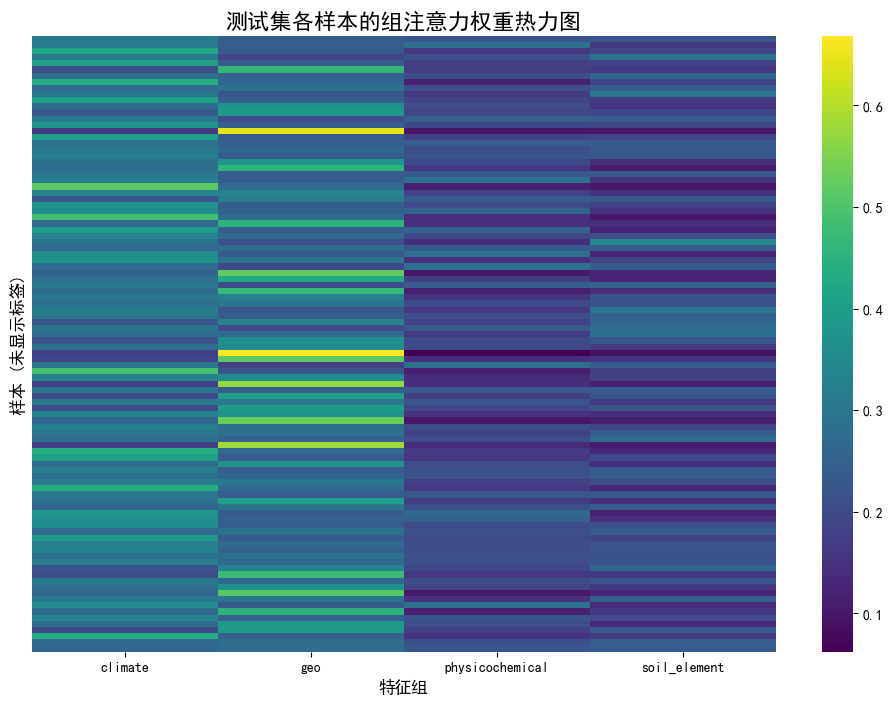

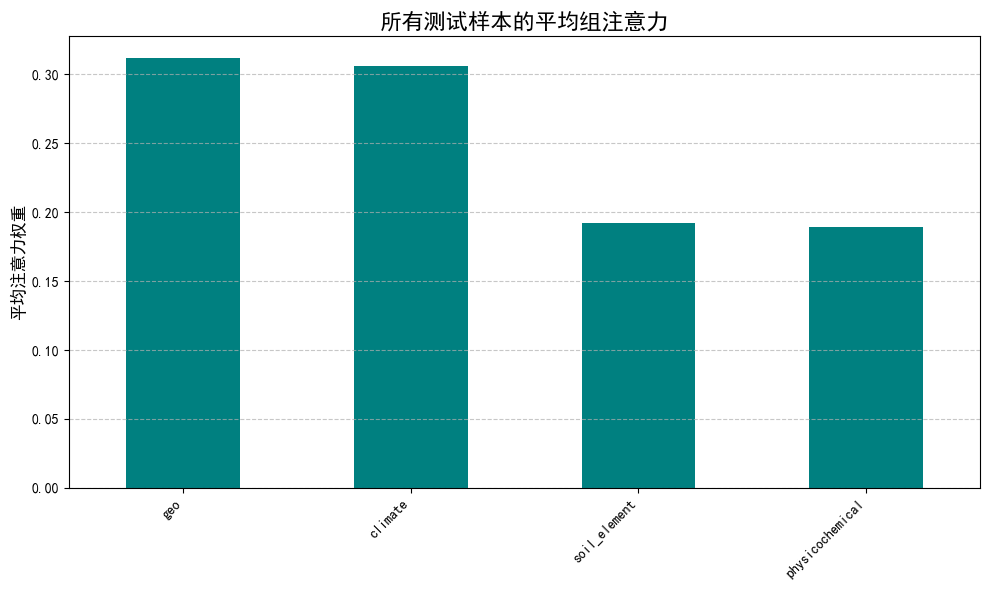


高产 vs 低产样本的平均注意力对比:
                      高产组       低产组
climate          0.310780  0.304387
geo              0.284861  0.321161
physicochemical  0.192000  0.188646
soil_element     0.212359  0.185807


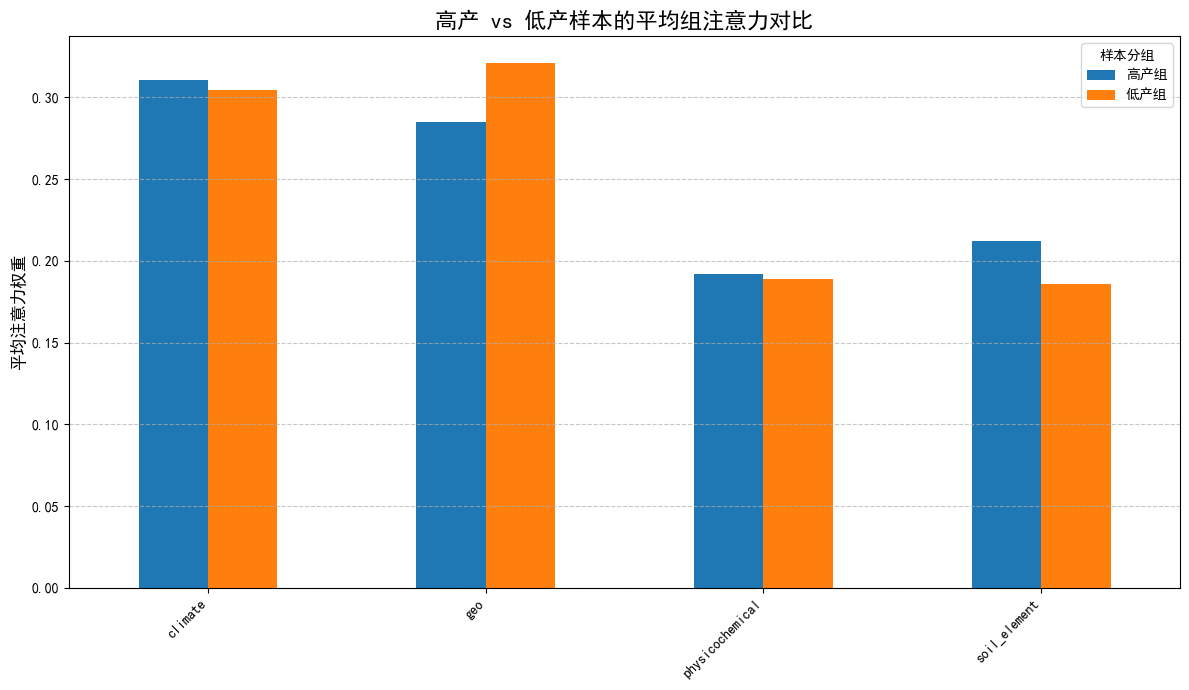

In [16]:
# 1. 获取测试集的注意力分数
# test_pred_outputs 是一个列表: [reconstruction, prediction, attention_scores]
_, _, test_attention_scores = test_pred_outputs

# 2. 将分数和组名对应起来，创建DataFrame
group_names = list(feature_groups.keys())
attention_df = pd.DataFrame(test_attention_scores, columns=group_names, index=X_test.index)

print("=" * 50)
print("动态组注意力分析:")
print("=" * 50)
print("测试集样本的注意力分数 (前5个样本):")
print(attention_df.head())

# 3. 可视化注意力分数

# a. 绘制注意力分数的整体分布热力图
plt.figure(figsize=(12, 8))
sns.heatmap(attention_df, cmap='viridis', xticklabels=True, yticklabels=False)
plt.title('测试集各样本的组注意力权重热力图', fontsize=16)
plt.xlabel('特征组', fontsize=12)
plt.ylabel('样本 (未显示标签)', fontsize=12)
plt.show()

# b. 绘制平均注意力重要性
mean_attention = attention_df.mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
mean_attention.plot(kind='bar', color='teal')
plt.title('所有测试样本的平均组注意力', fontsize=16)
plt.ylabel('平均注意力权重', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# c. 分析高产/低产样本的注意力差异 (示例)
# 合并预测结果和注意力分数
y_test_pred_df = pd.DataFrame(test_target_pred_orig, index=X_test.index, columns=['predicted_value'])
attention_with_pred = pd.concat([attention_df, y_test_pred_df], axis=1)

# 根据预测值定义高产和低产组
quantile_threshold = attention_with_pred['predicted_value'].quantile(0.75)
high_yield_samples = attention_with_pred[attention_with_pred['predicted_value'] >= quantile_threshold]
low_yield_samples = attention_with_pred[attention_with_pred['predicted_value'] < quantile_threshold]

# 计算并比较两组的平均注意力
mean_attn_high = high_yield_samples[group_names].mean().rename('高产组')
mean_attn_low = low_yield_samples[group_names].mean().rename('低产组')
comparison_df = pd.concat([mean_attn_high, mean_attn_low], axis=1)

print("\n高产 vs 低产样本的平均注意力对比:")
print(comparison_df)

# 绘制对比图
comparison_df.plot(kind='bar', figsize=(12, 7))
plt.title('高产 vs 低产样本的平均组注意力对比', fontsize=16)
plt.ylabel('平均注意力权重', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='样本分组')
plt.tight_layout()
plt.show()

In [17]:
# 从训练好的GSDAE模型中按名称获取组选择层的实例
group_selective_layer_instance = GSDAE.get_layer('improved_group_selective_layer')

# 使用RMS（L2范数并归一化）作为组评分标准进行分析
sorted_groups, feature_importance, weights = analyze_feature_importance(
    group_selective_layer_instance, 
    feature_groups, # 注意：这里使用的是最后一次实验的 feature_groups
    feature_names,
    metric='l2', 
    normalize=True
)

print("=" * 50)
print("最终模型 - 特征重要性分析:")
print("=" * 50)
print("\n特征组重要性排名 (RMS):")
for i, (group_name, importance) in enumerate(sorted_groups):
    print(f"{i+1:2d}. {group_name:12s}: {importance:.4f}")

print("\n各组内关键特征 (前3个):")
for group_name, features in feature_importance.items():
    print(f"\n{group_name}:")
    for i, (feat_name, weight) in enumerate(features[:3]):
        print(f"  {i+1}. {feat_name}: {weight:.4f}")

最终模型 - 特征重要性分析:

特征组重要性排名 (RMS):
 1. climate     : 0.7407
 2. soil_element: 0.7191
 3. physicochemical: 0.6419
 4. geo         : 0.6288

各组内关键特征 (前3个):

climate:
  1. Tmax: 0.9286
  2. GP: 0.9080
  3. MTWA: 0.8190

geo:
  1. Latitude: 0.8701
  2. Longitude: 0.6811
  3. Landscape_Mountain: 0.5697

physicochemical:
  1. N.N: 0.8425
  2. OM: 0.7564
  3. NH4_N: 0.7547

soil_element:
  1. Sr_S: 0.9850
  2. Zr_S: 0.9190
  3. Ca_S: 0.9035


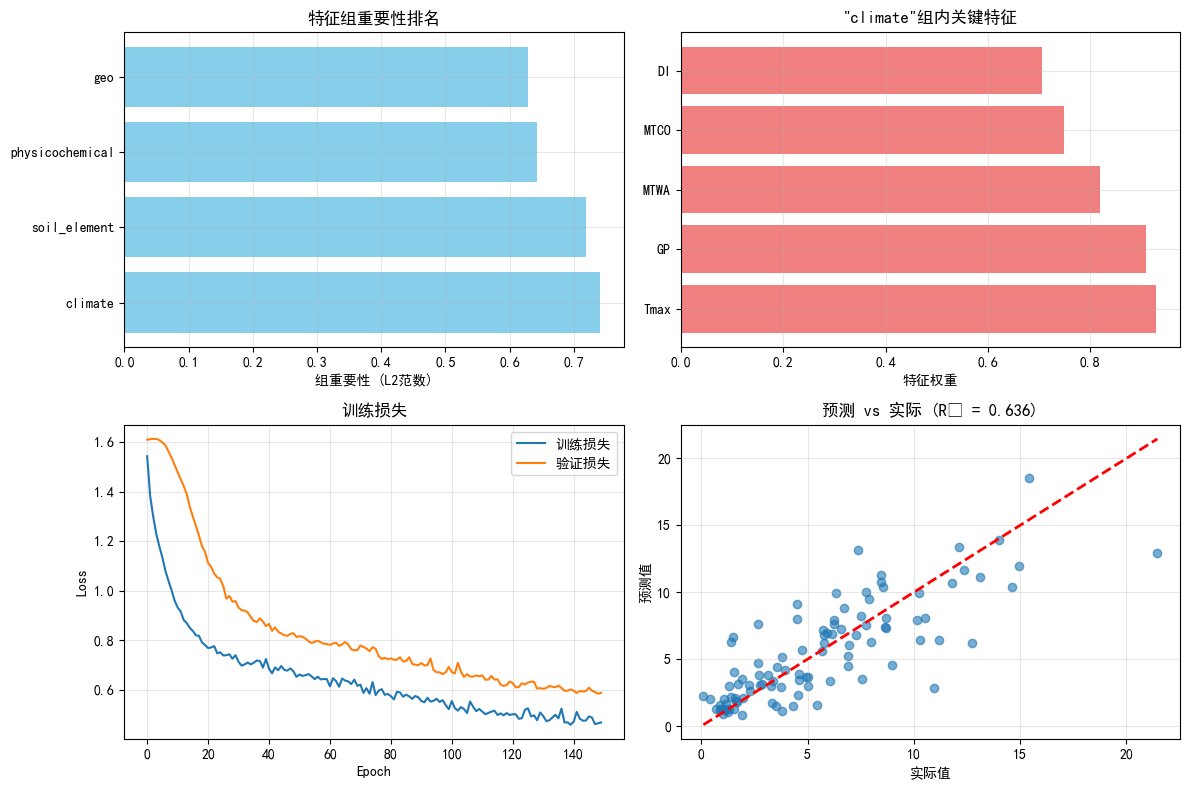

In [18]:
# 可视化结果
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 组重要性
top_n_groups = min(8, len(sorted_groups))
groups = [item[0] for item in sorted_groups[:top_n_groups]]
importance = [item[1] for item in sorted_groups[:top_n_groups]]

axes[0, 0].barh(groups, importance, color='skyblue')
axes[0, 0].set_xlabel('组重要性 (L2范数)')
axes[0, 0].set_title('特征组重要性排名')
axes[0, 0].grid(True, alpha=0.3)

# 最重要组的关键特征
if sorted_groups:
    top_group = sorted_groups[0][0]
    top_features = feature_importance[top_group][:5]
    
    feature_names_short = [item[0][:15] + '...' if len(item[0]) > 15 else item[0] for item in top_features]
    feature_weights = [item[1] for item in top_features]
    
    axes[0, 1].barh(feature_names_short, feature_weights, color='lightcoral')
    axes[0, 1].set_xlabel('特征权重')
    axes[0, 1].set_title(f'"{top_group}"组内关键特征')
    axes[0, 1].grid(True, alpha=0.3)

# 训练损失
axes[1, 0].plot(history_gsdae.history['loss'], label='训练损失')
axes[1, 0].plot(history_gsdae.history['val_loss'], label='验证损失')
axes[1, 0].set_title('训练损失')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 预测准确性
axes[1, 1].scatter(y_test_orig, test_target_pred_orig, alpha=0.6)
axes[1, 1].plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('实际值')
axes[1, 1].set_ylabel('预测值')
axes[1, 1].set_title(f'预测 vs 实际 (R² = {test_r2:.3f})')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary\n
\n
### GSDAE模型总结\n
\n
本notebook实现了基于方案文档的GSDAE模型，主要改进包括：\n
\n
1. **组稀疏正则化**: 针对生态因子的天然分组结构\n
2. **半监督学习**: 引入丹参酮含量作为监督信号\n
3. **预测头**: 专门的预测分支用于药效成分含量预测\n
4. **复合损失函数**: 重构误差 + 预测误差 + 组稀疏正则化\n
5. **两层重要性分析**: 组重要性评估 + 组内关键特征识别\n
\n
### 模型优势\n
\n
- **生物学意义**: 特征分组符合生态因子的天然结构\n
- **目标导向**: 半监督学习机制与药效预测任务对齐\n
- **可解释性**: 提供宏观到微观的多层次分析结果\n
- **实用性**: 同时完成特征选择、降维和预测任务

#### 绘制图


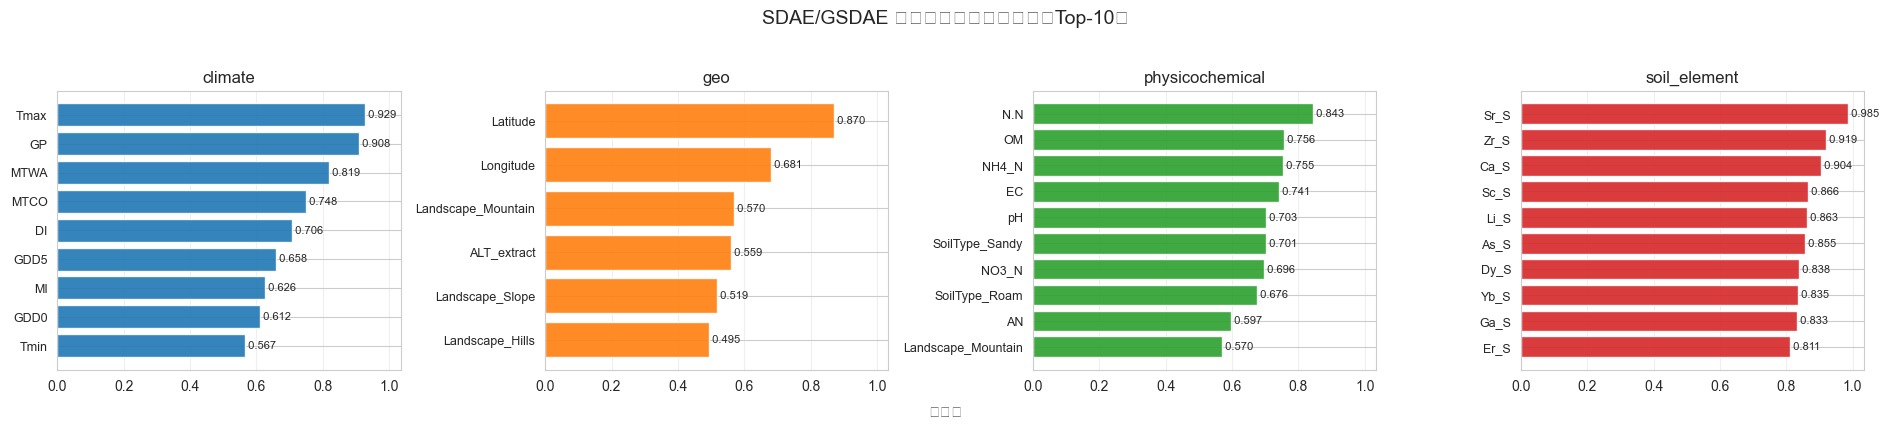

In [19]:
# 可视化：各特征组 Top-10 特征权重分布面板（类似图1）
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

sns.set_style("whitegrid")

def _get_layer_kernel(layer):
    if hasattr(layer, "kernel") and layer.kernel is not None:
        w = layer.kernel.numpy()
        return np.asarray(w, dtype=float)
    raise ValueError("layer 不含 kernel 权重，请确认传入的是 GroupSelectiveLayer/ImprovedGroupSelectiveLayer 的实例。")

def compute_group_feature_weights(layer, feature_groups, feature_names):
    """返回 {组名: [(特征名, 权重), ...]}"""
    weights = _get_layer_kernel(layer)
    result = {}
    for g, idx in feature_groups.items():
        if len(idx) == 0:
            continue
        pairs = [(feature_names[i], float(weights[i])) for i in idx]
        # 只保留非负权重（该层已约束到[0,1]，此处为稳健性）
        pairs = [(n, max(0.0, w)) for n, w in pairs]
        result[g] = pairs
    return result

def plot_group_weight_panels(group_feature_weights, top_k=10, group_order=None, ncols=4):
    """绘制各组Top-K特征权重面板"""
    # 组显示顺序
    keys = list(group_feature_weights.keys())
    if group_order:
        ordered = [g for g in group_order if g in group_feature_weights] + [g for g in keys if g not in group_order]
    else:
        ordered = keys

    ordered_map = OrderedDict((g, group_feature_weights[g]) for g in ordered)
    ng = len(ordered_map)
    ncols = min(ncols, max(1, ng))
    nrows = int(np.ceil(ng / ncols))

    # 统一x轴上限，便于对比
    global_max = 0.0
    for feats in ordered_map.values():
        if feats:
            global_max = max(global_max, max(w for _, w in feats))
    global_max = max(global_max, 1e-6) * 1.05

    # 颜色：每组一个主色
    palette = sns.color_palette("tab10", n_colors=max(10, ng))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4.6*ncols+0.6, 3.2*nrows+1), squeeze=False, sharex=True)
    ax_list = axes.flatten()

    # 先关掉所有坐标轴，避免空格子显示框线
    for ax in ax_list:
        ax.axis("off")

    for i, (g, feats) in enumerate(ordered_map.items()):
        ax = ax_list[i]
        ax.axis("on")
        feats_sorted = sorted(feats, key=lambda x: x[1], reverse=True)[:top_k]
        # 反向画水平条，便于从上到下显示从小到大
        names = [n if len(n) <= 18 else n[:18] + "…" for n, _ in feats_sorted][::-1]
        vals = [v for _, v in feats_sorted][::-1]

        ax.barh(names, vals, color=palette[i % len(palette)], alpha=0.9)
        ax.set_title(g, fontsize=12, pad=6)
        ax.set_xlim(0, global_max)
        ax.grid(True, axis='x', alpha=0.3)
        ax.tick_params(axis='y', labelsize=9)

        # 数值标注
        for y, v in enumerate(vals):
            ax.text(v, y, f" {v:.3f}", va='center', ha='left', fontsize=8)

    # 总标题与公共x轴标签
    fig.suptitle("SDAE/GSDAE 各特征组权重分布（每组Top-10）", fontsize=14)
    fig.text(0.5, 0.01, "权重值", ha='center', fontsize=11)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 使用示例（训练完成后运行）
# 从训练好的GSDAE模型中按名称获取组选择层的实例
try:
    layer_inst = GSDAE.get_layer('improved_group_selective_layer')
    if layer_inst is None:
        raise RuntimeError("在GSDAE模型中未找到名为 'improved_group_selective_layer' 的层。")
except NameError:
    raise NameError("模型 'GSDAE' 未定义。请确保前面的模型训练单元格已成功运行。")


group_feature_weights = compute_group_feature_weights(layer_inst, feature_groups, feature_names)

# 推荐的组显示顺序（若某组不存在会自动跳过）
preferred_order = ["土壤元素", "作物元素", "土壤养分", "地理信息", "气候环境",
                   "省份", "城市", "地貌", "土壤类型", "栽培类型", "气候类型"]

plot_group_weight_panels(group_feature_weights, top_k=10, group_order=preferred_order, ncols=4)

已设置中文字体: Microsoft YaHei


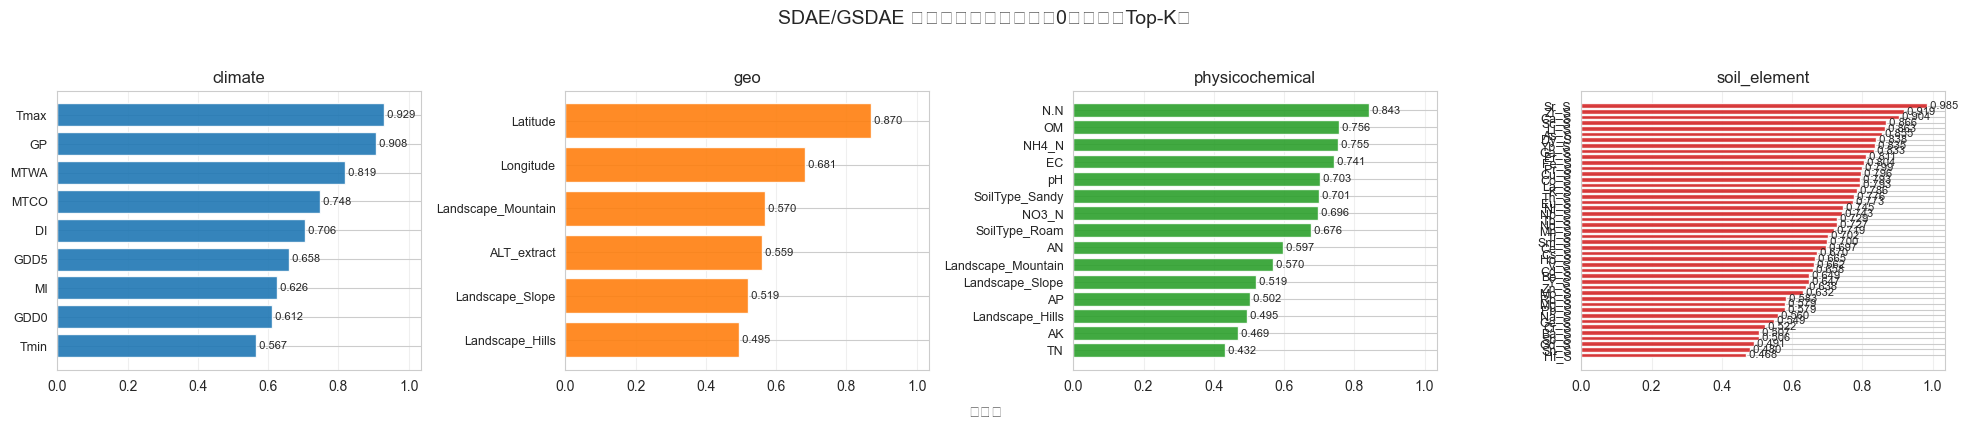

In [20]:
# 中文字体与“0权重可见”的权重面板图
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from matplotlib import font_manager as fm
from matplotlib.font_manager import FontProperties

def set_cn_font():
    """自动注册并启用中文字体"""
    candidates = [
        r"C:\Windows\Fonts\msyh.ttc",   # 微软雅黑
        r"C:\Windows\Fonts\msyh.ttf",
        r"C:\Windows\Fonts\simhei.ttf", # 黑体
        r"C:\Windows\Fonts\simsun.ttc"  # 宋体
    ]
    chosen = None
    for p in candidates:
        if os.path.exists(p):
            try:
                fm.fontManager.addfont(p)
                chosen = FontProperties(fname=p).get_name()
                break
            except Exception:
                pass
    if chosen is None:
        # 回退到常用名称
        chosen = "Microsoft YaHei"
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = [chosen, 'SimHei', 'SimSun', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    print(f"已设置中文字体: {chosen}")

set_cn_font()
sns.set_style("whitegrid")

def _get_layer_kernel(layer):
    if hasattr(layer, "kernel") and layer.kernel is not None:
        w = layer.kernel.numpy()
        return np.asarray(w, dtype=float)
    raise ValueError("layer 不含 kernel 权重，请确认传入的是 GroupSelectiveLayer/ImprovedGroupSelectiveLayer 的实例。")

def compute_group_feature_weights(layer, feature_groups, feature_names):
    """返回 {组名: [(特征名, 权重), ...]}（包含0值）"""
    weights = _get_layer_kernel(layer)
    result = {}
    for g, idx in feature_groups.items():
        
        if len(idx) == 0:
            continue
        pairs = [(feature_names[i], float(max(0.0, weights[i]))) for i in idx]  # 负值截断为0，保留0
        result[g] = pairs
    return result

def plot_group_weight_panels(group_feature_weights, top_k=None, group_order=None, ncols=4, zero_min_ratio=0.02):
    """
    绘制各组Top-K特征权重面板
    - top_k=None 显示组内全部特征
    - zero_min_ratio: 0值条形显示为 (global_max * ratio) 的最小宽度
    """
    # 组显示顺序
    keys = list(group_feature_weights.keys())
    if group_order:
        ordered = [g for g in group_order if g in group_feature_weights] + [g for g in keys if g not in group_order]
    else:
        ordered = keys

    ordered_map = OrderedDict((g, group_feature_weights[g]) for g in ordered)
    ng = len(ordered_map)
    ncols = min(ncols, max(1, ng))
    nrows = int(np.ceil(ng / ncols))

    # 统一x轴上限，便于对比（按真实权重计算）
    all_vals = [w for feats in ordered_map.values() for _, w in feats] or [0.0]
    global_max = float(max(all_vals))
    if global_max <= 0:
        global_max = 1.0  # 全0时的可视上限
    xlim = global_max * 1.05
    min_bar = max(global_max * zero_min_ratio, 1e-6)  # 0值条的最小显示宽度

    palette = sns.color_palette("tab10", n_colors=max(10, ng))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.8*ncols+0.6, 3.2*nrows+1), squeeze=False, sharex=True)
    ax_list = axes.flatten()

    # 先关掉所有坐标轴，避免空格子显示框线
    for ax in ax_list:
        ax.axis("off")

    for i, (g, feats) in enumerate(ordered_map.items()):
        ax = ax_list[i]
        ax.axis("on")
        feats_sorted = sorted(feats, key=lambda x: x[1], reverse=True)
        if top_k is not None:
            feats_sorted = feats_sorted[:top_k]

        names = [n if len(n) <= 18 else n[:18] + "…" for n, _ in feats_sorted][::-1]
        vals_true = [v for _, v in feats_sorted][::-1]
        # 0值条形使用最小宽度渲染，但保留真实数值标注
        vals_plot = [v if v > 0 else min_bar for v in vals_true]

        ax.barh(names, vals_plot, color=palette[i % len(palette)], alpha=0.9)
        ax.set_title(g, fontsize=12, pad=6)
        ax.set_xlim(0, xlim)
        ax.grid(True, axis='x', alpha=0.3)
        ax.tick_params(axis='y', labelsize=9)

        # 数值标注（使用真实值；位置用绘制宽度以保证可见）
        for y, (vp, vt) in enumerate(zip(vals_plot, vals_true)):
            ax.text(vp, y, f" {vt:.3f}", va='center', ha='left', fontsize=8)

    fig.suptitle("SDAE/GSDAE 各特征组权重分布（含0值；每组Top-K）", fontsize=14)
    fig.text(0.5, 0.01, "权重值", ha='center', fontsize=11)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
# 从训练好的GSDAE模型中按名称获取组选择层的实例
try:
    layer_inst = GSDAE.get_layer('improved_group_selective_layer')
    if layer_inst is None:
        raise RuntimeError("在GSDAE模型中未找到名为 'improved_group_selective_layer' 的层。")
except NameError:
    raise NameError("模型 'GSDAE' 未定义。请确保前面的模型训练单元格已成功运行。")


group_feature_weights = compute_group_feature_weights(layer_inst, feature_groups, feature_names)
# 推荐顺序；top_k=None 显示组内全部特征（包含0）
preferred_order = ["土壤元素", "作物元素", "土壤养分", "地理信息", "气候环境",
                   "省份", "城市", "地貌", "土壤类型", "栽培类型", "气候类型"]

plot_group_weight_panels(group_feature_weights, top_k=None, group_order=preferred_order, ncols=4, zero_min_ratio=0.02)

结果将保存在 'results' 文件夹中。

GSDAE 模型分析报告 (2025-11-18 16:51:22)

### 2. 模型评估指标 ###
 - 目标预测 - 测试 R²: 0.6357
 - 目标预测 - 测试 MAE (原单位): 1.780810
 - 目标预测 - 训练 R²: 0.7156
 - 目标预测 - 训练 MAE (原单位): 1.726018
--------------------
 - 重构任务 - 测试 MSE: 0.507685
 - 预测任务 - 测试 MSE: 0.322351

### 3. 特征组重要性排名 (RMS) ###
 1. climate     : 0.7407
 2. soil_element: 0.7191
 3. physicochemical: 0.6419
 4. geo         : 0.6288

### 4. 各组内关键特征 (Top 3) ###

--- climate ---
  1. Tmax: 0.9286
  2. GP: 0.9080
  3. MTWA: 0.8190

--- geo ---
  1. Latitude: 0.8701
  2. Longitude: 0.6811
  3. Landscape_Mountain: 0.5697

--- physicochemical ---
  1. N.N: 0.8425
  2. OM: 0.7564
  3. NH4_N: 0.7547

--- soil_element ---
  1. Sr_S: 0.9850
  2. Zr_S: 0.9190
  3. Ca_S: 0.9035

✅ 文本摘要已保存至: results\model_summary.txt


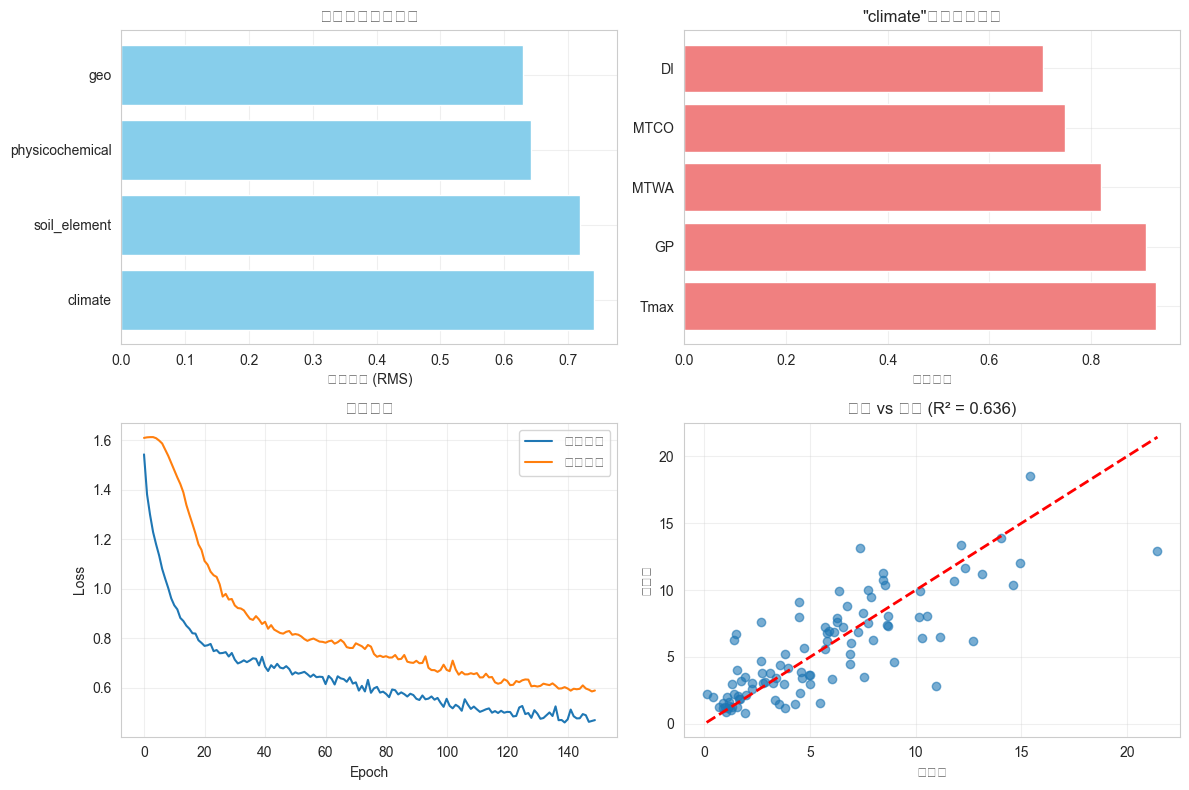

✅ 综合评估图已保存至: results\evaluation_summary.png


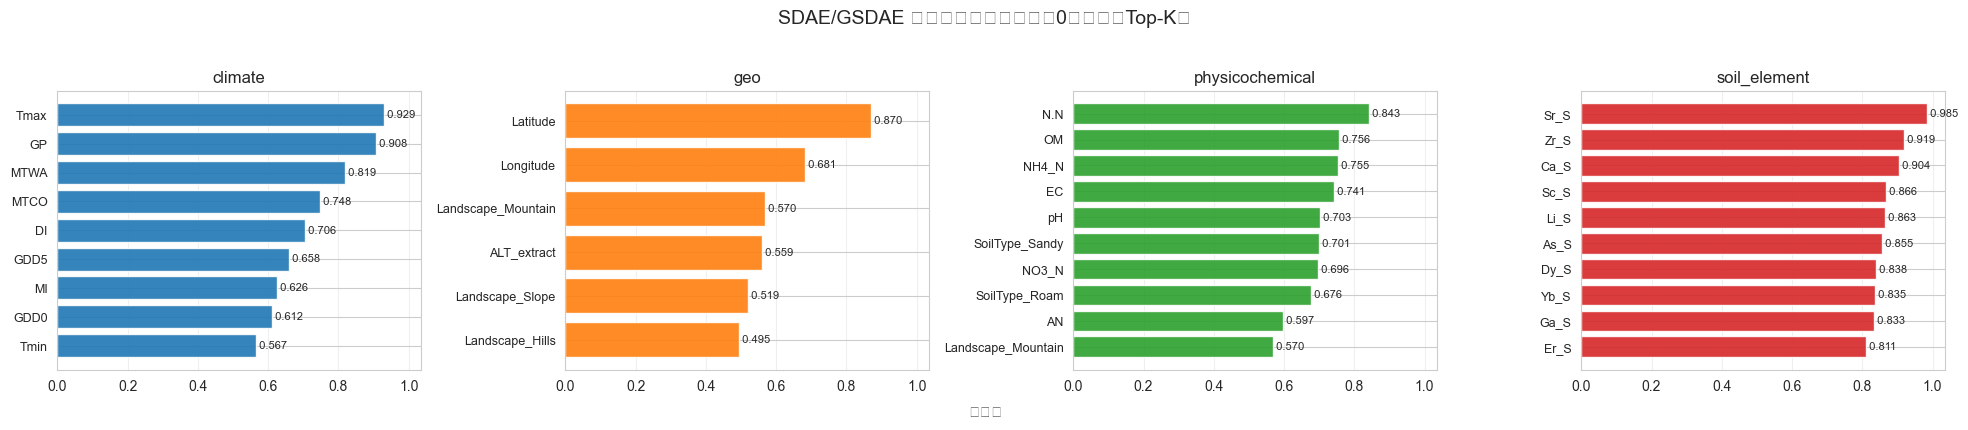

✅ Top-10 特征权重图已保存至: results\feature_weights_top10.png


<Figure size 640x480 with 0 Axes>

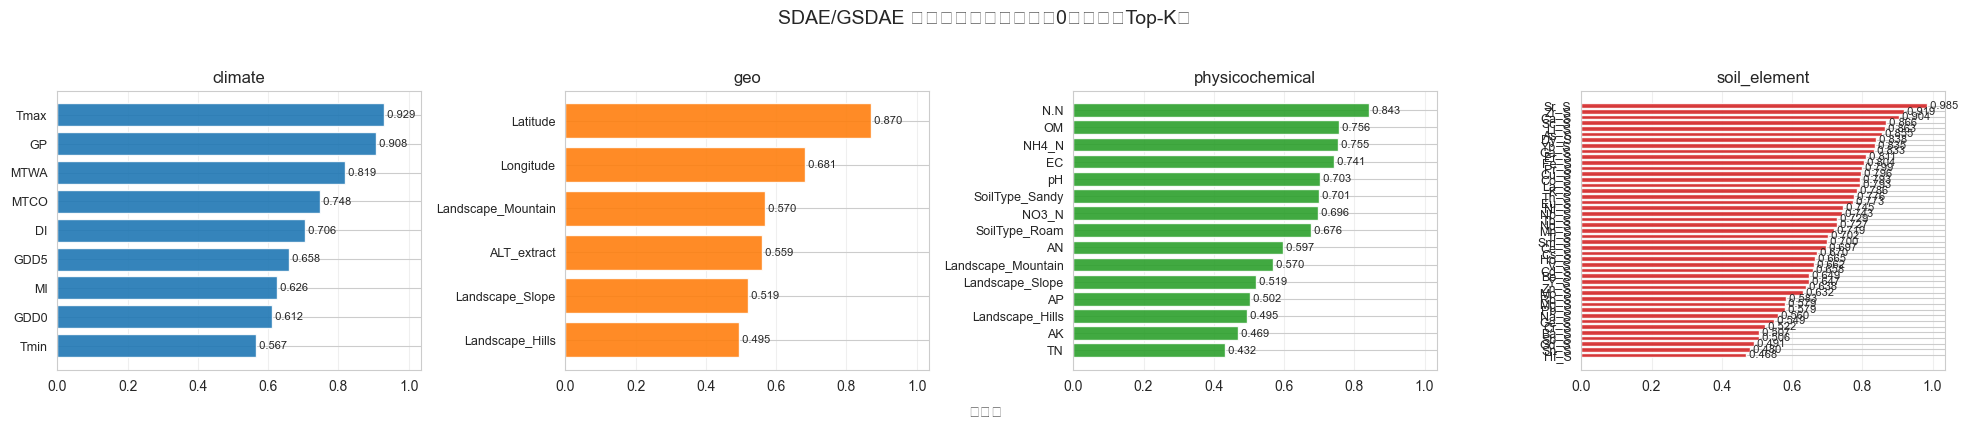

✅ 全特征权重图已保存至: results\feature_weights_all.png


<Figure size 640x480 with 0 Axes>

In [21]:


# --- 1. 创建结果输出目录 ---
output_dir = 'results'
os.makedirs(output_dir, exist_ok=True)
print(f"结果将保存在 '{output_dir}' 文件夹中。\n")

# --- 2. 准备文本摘要内容 ---
summary_content = []
summary_content.append("=" * 50)
summary_content.append(f"GSDAE 模型分析报告 ({datetime.now().strftime('%Y-%m-%d %H:%M:%S')})")
summary_content.append("=" * 50)

# a. 最佳超参数
if 'best_hps' in locals():
    summary_content.append("\n### 1. 最佳超参数 ###")
    summary_content.append(f" - learning_rate: {best_hps.get('learning_rate')}")
    summary_content.append(f" - group_lasso_rate: {best_hps.get('group_lasso_rate')}")
    summary_content.append(f" - l1_rate: {best_hps.get('l1_rate')}")
    summary_content.append(f" - prediction_weight: {best_hps.get('prediction_weight')}")

# b. 模型评估指标
summary_content.append("\n### 2. 模型评估指标 ###")
summary_content.append(f" - 目标预测 - 测试 R²: {test_r2:.4f}")
summary_content.append(f" - 目标预测 - 测试 MAE (原单位): {test_mae_pred_orig:.6f}")
summary_content.append(f" - 目标预测 - 训练 R²: {train_r2:.4f}")
summary_content.append(f" - 目标预测 - 训练 MAE (原单位): {train_mae_pred_orig:.6f}")
summary_content.append("-" * 20)
summary_content.append(f" - 重构任务 - 测试 MSE: {test_mse_recon:.6f}")
summary_content.append(f" - 预测任务 - 测试 MSE: {test_mse_pred:.6f}")

# c. 特征重要性
if 'sorted_groups' in locals() and 'feature_importance' in locals():
    summary_content.append("\n### 3. 特征组重要性排名 (RMS) ###")
    for i, (group_name, importance) in enumerate(sorted_groups):
        summary_content.append(f"{i+1:2d}. {group_name:12s}: {importance:.4f}")

    summary_content.append("\n### 4. 各组内关键特征 (Top 3) ###")
    for group_name, features in feature_importance.items():
        summary_content.append(f"\n--- {group_name} ---")
        for i, (feat_name, weight) in enumerate(features[:3]):
            summary_content.append(f"  {i+1}. {feat_name}: {weight:.4f}")

# --- 3. 打印并保存文本摘要 ---
summary_text = "\n".join(summary_content)
print(summary_text)

summary_filepath = os.path.join(output_dir, 'model_summary.txt')
with open(summary_filepath, 'w', encoding='utf-8') as f:
    f.write(summary_text)
print(f"\n✅ 文本摘要已保存至: {summary_filepath}")


# --- 4. 重新生成并保存所有图表 ---

# a. 保存综合评估图
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# 组重要性
top_n_groups = min(8, len(sorted_groups))
groups = [item[0] for item in sorted_groups[:top_n_groups]]
importance = [item[1] for item in sorted_groups[:top_n_groups]]
axes[0, 0].barh(groups, importance, color='skyblue')
axes[0, 0].set_xlabel('组重要性 (RMS)')
axes[0, 0].set_title('特征组重要性排名')
axes[0, 0].grid(True, alpha=0.3)
# 最重要组的关键特征
if sorted_groups:
    top_group = sorted_groups[0][0]
    top_features = feature_importance[top_group][:5]
    feature_names_short = [item[0][:15] + '...' if len(item[0]) > 15 else item[0] for item in top_features]
    feature_weights = [item[1] for item in top_features]
    axes[0, 1].barh(feature_names_short, feature_weights, color='lightcoral')
    axes[0, 1].set_xlabel('特征权重')
    axes[0, 1].set_title(f'"{top_group}"组内关键特征')
    axes[0, 1].grid(True, alpha=0.3)
# 训练损失
axes[1, 0].plot(history_gsdae.history['loss'], label='训练损失')
axes[1, 0].plot(history_gsdae.history['val_loss'], label='验证损失')
axes[1, 0].set_title('训练损失')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
# 预测准确性
axes[1, 1].scatter(y_test_orig, test_target_pred_orig, alpha=0.6)
axes[1, 1].plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('实际值')
axes[1, 1].set_ylabel('预测值')
axes[1, 1].set_title(f'预测 vs 实际 (R² = {test_r2:.3f})')
axes[1, 1].grid(True, alpha=0.3)
plt.tight_layout()
eval_fig_path = os.path.join(output_dir, 'evaluation_summary.png')
plt.savefig(eval_fig_path, dpi=300)
plt.show()
print(f"✅ 综合评估图已保存至: {eval_fig_path}")

# b. 保存 Top-10 特征权重图
plot_group_weight_panels(group_feature_weights, top_k=10, group_order=preferred_order, ncols=4)
top10_fig_path = os.path.join(output_dir, 'feature_weights_top10.png')
plt.savefig(top10_fig_path, dpi=300)
print(f"✅ Top-10 特征权重图已保存至: {top10_fig_path}")


# c. 保存全特征权重图
plot_group_weight_panels(group_feature_weights, top_k=None, group_order=preferred_order, ncols=4, zero_min_ratio=0.02)
all_weights_fig_path = os.path.join(output_dir, 'feature_weights_all.png')
plt.savefig(all_weights_fig_path, dpi=300)
print(f"✅ 全特征权重图已保存至: {all_weights_fig_path}")